# Gradient Bandit algorithm (A k-armed bandit problem)
by  __Sandeep Banik and Shivangi Agarwal__ | Reinforcement Learning

All of the pervious methods show some methods of choosing a action based on $Q$ values estimates and some randomness leading to a balance between exploration and exploitation. Here we provide a method to quantitatively prefer an action over the others. This method is not dependent on the $Q$ value estimates and is a result of the rewards gained in choosing an action $a$. Only relative preference matter, therefore any offset values added to all does not deviate from the current preference. The probability of choosing an action is given by the Gibbs distribution as,

$$Pr\{A_{t}=a\} \overset{.}{=} \frac{e^{H_{t}(a)}}{\sum_{i=1}^{n} e^{H_t(i)}} \overset{.}{=} \pi_{t}(a)$$

Here $A_{t}$ is action chosen at the time $t$, $H_{t}(a)$ is the numerical preference of choosing an action $a$ at the time t, $\pi_{t}(a)$ is the probability distribution of choosing an action $a$ at a given time $t$. Initially we would like no preference over any action leading to $H_{0}(a) = 0$ $\forall a \in \{1,2,..n\}$

## Update rule of $H_t(a)$

The update rule for the numerical preference is given as, 

$ H_{t+1}(a) = H_{t}(a) + \alpha(R_{t} - \bar{R_t})(1 - \pi_t(A_t)) \quad \quad \quad \text{and}$ 

$ H_{t+1}(a) = H_{t}(a) - \alpha(R_{t} - \bar{R_t})\pi_t(A_t) \quad \quad \quad \text{for all  } a \neq A_{t}$

where $\alpha$ is the step size (user defined), $R_{t}$ is the current reward and $\bar{R_t}$ is the average reward upto the time $t$. 
As observed the probability distribution changes over time. A small example is illustrated as follows. Consider a machine with 3 actions or arms. Initially we begin with equal preference i.e., $H_0{(a)} = 0$ for $a = 1,2,3$. 

<img src="Images/Gradient bandit - probability.png">

The probability distribution keeps changing over time adjusting to the rewards. The average reward $\bar{R_{t}}$ serves as a baseline, without which the gradient bandit would fail to perform. 

When a particular action is chosen the corresponding difference between rewards and average reward ($R_{t} - \bar{R_{t}}$) either creates a greater preference (when positive) or lowers it (when negative). Similarly this affects other actions as well when the difference ($R_{t} - \bar{R_{t}}$) is positive the numerical preference lowers and when difference is negtive, preference increases. 

## Code and analysis

In [1]:
#%% Library imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#%% Initialisations

# Total number of bandit arms
n = 10

# Total number of experiments
t = 1000

# Number of bandits(episodes)
bandit_number = 2000

# Q star values.
Q_star = np.random.normal(loc = 4.0, scale = 1.0, size = (bandit_number,n))

# Step size.
alpha = [0.1,0.4,0.1,0.4]

# Baseline
base = [1, 1, 0, 0]

# Optimal action that should be chosen for each bandit
a_opt = np.zeros((len(alpha),t))

# Reward for each corresponding alpha and baseline.
avg_rew = np.zeros((len(alpha),t))

#####################
# Bandit or machine
#####################

def bandit(a, ids):
    R = np.random.normal(loc=Q_star[ids,a],scale=1,size=1)
    return R

In [4]:
#%% Gradient bandit algorithm.
for k in range(len(base)):
    # Q estimates for each corresponding alpha and baseline.
    Q = np.zeros((bandit_number,n))

    # Numerical preference of each action for each bandit.
    H = np.zeros((bandit_number,n,t+1))

    reward_t = np.zeros(bandit_number)

    reward_store = np.zeros((bandit_number,t))

    for episode in range(1,t):
        action_history = 0.0
        local_reward = 0.0
        for machine in range(bandit_number):
            # Cache the exponential sum
            exp_sum = np.sum(np.exp(H[machine,:,episode]))

            # Probability distribution.
            pi_dis = np.exp(H[machine,:,episode])/exp_sum
            #pi_store.append(pi_dis)
            # Action taken
            a = np.random.choice(np.arange(n),p = pi_dis)

            # Reward for choosing an action a for corresponding machine
            rewards = bandit(a,machine)
            local_reward += rewards

            Q[machine,a] = Q[machine,a] + 0.1*(rewards-Q[machine,a])

            # Calculating an optimal action for each bandit
            idx = np.argmax(Q_star[machine,:])

            action_history += (a==idx)

            # Update the current reward (upto time t), as decribed in section 2.4 (Sutton and Barto)
            reward_t[machine] =  reward_t[machine] + 1.0/(episode)*(rewards - reward_t[machine])

            reward_store[machine,episode] = rewards
            # Baseline check.
            if base[k] == 0:
                reward_t[machine] = 0

           # Update the numerical preference.
            H[machine,:,episode+1] = H[machine,:,episode] + \
                            alpha[k]*(rewards - reward_t[machine])*(1 - pi_dis[a])*(np.arange(n)==a) - \
                            alpha[k]*(rewards - reward_t[machine])*(pi_dis)*(np.arange(n)!=a)

        a_opt[k,episode]= (action_history/bandit_number)

        avg_rew[k,episode] = (local_reward/bandit_number)


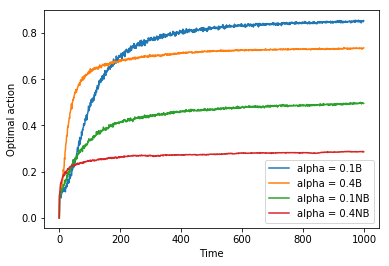

In [5]:
#%% Plot graph of percentage of chossing optimal actions

act_plt = ['B','B','NB','NB']

for k in range(len(alpha)):
    plt.plot(a_opt[k,:].T,label = 'alpha = ' + str(alpha[k]) + act_plt[k])
plt.xlabel('Time')
plt.ylabel('Optimal action')
plt.legend()